In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from math import ceil

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Helper functions to calculate metrics

In [2]:
from findpeaks import findpeaks
from scipy.ndimage.measurements import label

In [3]:
# Area and Peaks

def get_area_and_peaks(firing_field):
    firing_field = firing_field/firing_field.max()
    area_thresh = ceil(0.00716197244*firing_field.size)
    masked_field = firing_field > 0.8
    labeled_array, ncomponents = label(masked_field, np.ones((3,3)))
    areas = []
    for label_id in np.unique(labeled_array):
        if label_id == 0: continue
        area = np.sum(labeled_array == label_id)
        if area < area_thresh: continue
        areas.append(area)
    return areas, len(areas)

# Spatial Info

def flatten_xy(walk_xs, walk_ys):
    max_col = walk_ys.max()
    new_bins = walk_xs * max_col + walk_ys
    return new_bins

def circular(fr):
    """
    Circularly shuffles a (neur, frames) array of firing rates, neuron by neuron.
    """

    fr = fr.copy()
    shift = np.random.choice(np.arange(1, fr.size))
    if len(fr.shape) == 2:
        num_neur, num_frames = fr.shape
        for neur in range(num_neur):
            shift = np.random.choice(np.arange(1, num_frames))
            fr[neur,:] = np.roll(fr[neur,:], shift)
        return fr
    else:
        return np.roll(fr, shift)
    
def get_mutual_info(conditions, fr):
    """
    Calculates mutual information between firing rate and a set of conditions

    Args:
        conditions: (frames,) array of conditions
        fr: (neurs, frames) array of firing rates
    Returns:
        (neurs,) array of scaler value mutual information per neuron
    """

    num_neurs, _ = fr.shape
    mean_fr = np.mean(fr, axis=1)
    mutual_info = np.zeros(num_neurs)
    for condn in np.unique(conditions):
        prob = np.sum(conditions==condn)/conditions.size
        condn_mean_fr = np.mean(fr[:,conditions==condn], axis=1)
        log_term = np.log2(condn_mean_fr/mean_fr)
        log_term[np.isnan(log_term)] = 0
        log_term[np.isinf(log_term)] = 0
        mutual_info += prob*condn_mean_fr*log_term
    return mutual_info

def calc_place_cells(xs, ys, fr, num_shuffles):
    """ Gets the spatial mutual information of each cell."""

    num_neurs, num_frames = fr.shape
    spatial_info = np.zeros(num_neurs)
    significance = np.zeros(num_neurs)
    conditions = flatten_xy(xs, ys)
    spatial_info = get_mutual_info(conditions, fr)
    
    for _ in range(num_shuffles):
        shuffled_fr = circular(fr)
        shuffled_info = get_mutual_info(conditions, shuffled_fr)
        significance += (shuffled_info < spatial_info)
    significance /= num_shuffles
    
    return spatial_info, significance

def get_metrics(outputs, dset):
    walk_xs = dset.xs.astype(int)
    walk_ys = dset.ys.astype(int)
    arena_length = 10
    
    areas = []
    ncomps = []

#     spatial_info, significance = calc_place_cells(
#         walk_xs, walk_ys, outputs.T, 100
#         )

    for neur in np.arange(outputs.shape[1]):
        firing_field = np.zeros((arena_length, arena_length))*np.nan
        for x in range(arena_length):
            for y in range(arena_length):
                frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
                fr = np.nanmean(outputs[frame_idxs, neur])
                firing_field[x,y] = fr
        num_nonnans = firing_field.size - np.sum(np.isnan(firing_field))
        firing_field[np.isnan(firing_field)] = 0

        # Area?
        area, ncomp = get_area_and_peaks(firing_field)
        areas.append(np.sum(area)/num_nonnans)
        ncomps.append(ncomp)
    return np.array(areas), np.array(ncomps), None

# Specify dataset

In [4]:
num_states = 14*14

In [5]:
# N-hot inputs
feature_maker_kwargs = {
    'feature_dim': num_states*2, 'feature_type': 'nhot'
    }

# Uncorrelated inputs
feature_maker_kwargs = {
    'feature_dim': num_states,
    'feature_vals': [0, 1],
    'feature_vals_p': [0.97, 0.03]
    }

# Correlated inputs
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_vals': None,
    'feature_vals_p': [0.8, 0.2],
    'feature_type': 'correlated_distributed',
    'spatial_sigma': 1.75
    }

# # One hot
# feature_maker_kwargs = {
#     'feature_dim': num_states, 'feature_type': 'nhot'
#     }

dataset_config = {
    'num_steps': 3500, 'num_states': num_states,
    'feature_maker_kwargs': feature_maker_kwargs
    }
dataset = sf_inputs_discrete.Sim2DWalk


dataset_config = {
    'feature_maker_kwargs': feature_maker_kwargs,
    'num_steps': np.inf
    }
dataset = sf_inputs_discrete.TitmouseWalk

input_size = feature_maker_kwargs['feature_dim']

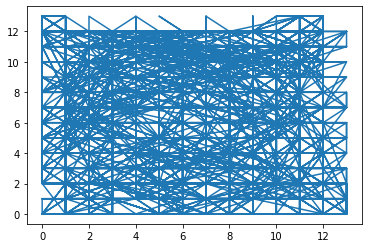

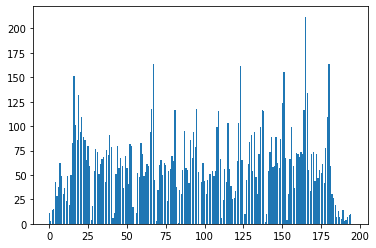

56.5


0.02040816326530612

In [6]:
input = dataset(**dataset_config)
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

plt.figure();
states = np.argwhere(input.state_inputs)[:,0]
counts = np.zeros(input.num_states)
for state in np.arange(input.num_states):
    counts[state] = np.sum(states==state)
plt.bar(np.arange(input.num_states), counts)
plt.show()
print(np.median(counts))
np.sum(counts == 0)/input.num_states

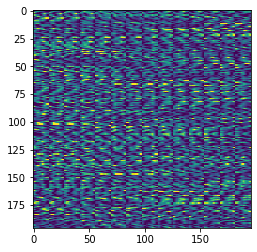

In [7]:
plt.figure()
plt.imshow(input.feature_maker.feature_map)
plt.show()

In [8]:
gamma=0.75

In [ ]:
areas = []
nfields = []
one_fields = []

for _ in range(10):
    rnn = AnalyticSR(
        num_states=input_size, gamma=gamma,
        ca3_kwargs={
            'use_dynamic_lr':False, 'lr': 1E-3,
            #'parameterize': True,
            'alpha': 1.2, 'beta': 1.2
            }
        )
    outputs, loss, dset = run_rnn(
        '../trained_models/test/', rnn, dataset,
        dataset_config, gamma=gamma, test_over_all=False,
        train_net=False, return_dset=True
        )
    walk_xs = dset.xs
    walk_ys = dset.ys
    arena_length = int(np.sqrt(dset.num_states))
    _areas, _ncomps, _ = get_metrics(outputs, dset)
    areas.append(np.mean(_areas))
    nfields.append(np.mean(_ncomps))
    one_fields.append(sum(_ncomps==1)/_ncomps.size)


[   51] loss: 0.028
Time per step 0.105s, net 5.229s

[  101] loss: 0.021
Time per step 0.094s, net 9.947s

[  151] loss: 0.015
Time per step 0.092s, net 14.522s

[  201] loss: 0.011
Time per step 0.085s, net 18.757s

[  251] loss: 0.007
Time per step 0.100s, net 23.742s

[  301] loss: 0.005
Time per step 0.107s, net 29.077s

[  351] loss: 0.003
Time per step 0.084s, net 33.255s

[  401] loss: 0.003
Time per step 0.082s, net 37.373s

[  451] loss: 0.002
Time per step 0.109s, net 42.828s

[  501] loss: 0.002
Time per step 0.105s, net 48.058s

[  551] loss: 0.002
Time per step 0.085s, net 52.314s

[  601] loss: 0.002
Time per step 0.086s, net 56.625s

[  651] loss: 0.001
Time per step 0.074s, net 60.345s

[  701] loss: 0.001
Time per step 0.115s, net 66.075s

[  751] loss: 0.001
Time per step 0.088s, net 70.470s

[  801] loss: 0.001
Time per step 0.091s, net 75.012s

[  851] loss: 0.001
Time per step 0.095s, net 79.743s

[  901] loss: 0.001
Time per step 0.135s, net 86.490s

[  951] los


[ 7401] loss: 0.001
Time per step 0.081s, net 770.202s

[ 7451] loss: 0.001
Time per step 0.076s, net 773.987s

[ 7501] loss: 0.001
Time per step 0.076s, net 777.771s

[ 7551] loss: 0.001
Time per step 0.055s, net 780.532s

[ 7601] loss: 0.001
Time per step 0.060s, net 783.518s

[ 7651] loss: 0.001
Time per step 0.055s, net 786.280s

[ 7701] loss: 0.001
Time per step 0.056s, net 789.069s

[ 7751] loss: 0.001
Time per step 0.056s, net 791.891s

[ 7801] loss: 0.001
Time per step 0.057s, net 794.749s

[ 7851] loss: 0.001
Time per step 0.057s, net 797.578s

[ 7901] loss: 0.001
Time per step 0.058s, net 800.472s

[ 7951] loss: 0.001
Time per step 0.058s, net 803.370s

[ 8001] loss: 0.001
Time per step 0.059s, net 806.339s

[ 8051] loss: 0.001
Time per step 0.056s, net 809.144s

[ 8101] loss: 0.001
Time per step 0.056s, net 811.936s

[ 8151] loss: 0.001
Time per step 0.063s, net 815.065s

[ 8201] loss: 0.001
Time per step 0.058s, net 817.956s

[ 8251] loss: 0.001
Time per step 0.084s, net 8

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars



[   51] loss: 0.065
Time per step 0.072s, net 3.606s

[  101] loss: 0.041
Time per step 0.078s, net 7.502s

[  151] loss: 0.030
Time per step 0.085s, net 11.740s

[  201] loss: 0.028
Time per step 0.103s, net 16.897s

[  251] loss: 0.027
Time per step 0.084s, net 21.109s

[  301] loss: 0.028
Time per step 0.079s, net 25.034s

[  351] loss: 0.030
Time per step 0.075s, net 28.806s

[  401] loss: 0.032
Time per step 0.078s, net 32.715s

[  451] loss: 0.032
Time per step 0.086s, net 37.005s

[  501] loss: 0.029
Time per step 0.106s, net 42.292s

[  551] loss: 0.027
Time per step 0.096s, net 47.082s

[  601] loss: 0.024
Time per step 0.077s, net 50.930s

[  651] loss: 0.025
Time per step 0.076s, net 54.714s

[  701] loss: 0.026
Time per step 0.083s, net 58.882s

[  751] loss: 0.029
Time per step 0.117s, net 64.729s

[  801] loss: 0.030
Time per step 0.095s, net 69.459s

[  851] loss: 0.030
Time per step 0.096s, net 74.267s

[  901] loss: 0.031
Time per step 0.087s, net 78.637s

[  951] los

In [ ]:
print(np.nanmean(areas))
areas

In [ ]:
print(np.mean(nfields))
nfields

In [ ]:
print(np.mean(one_fields))
one_fields

# Make Firing Field Plots

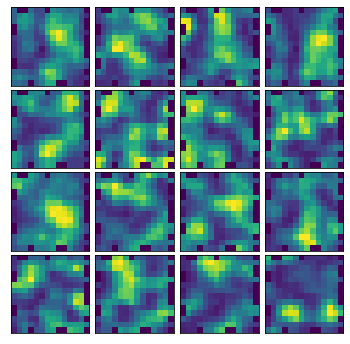

In [41]:
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0    
    if not np.any(firing_field > 0): continue
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    area, ncomp = get_area_and_peaks(firing_field)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.show()